In [1]:
import os, cv2
import numpy as np
import onnxruntime as ort
from torchvision import transforms
import numpy as np
from pathlib import Path
from fastai.vision.all import get_image_files

emotion7_list = ["surprise","fear","disgust","happy","sad","angry","neutral"]
inf7_list = ["surprise","fear","disgust","happy","sad","angry","neutral"]

#0: Surprise
#1: Fear
#2: Disgust
#3: Happiness
#4: Sadness
#5: Anger
#6: Neutral


In [2]:
# get the img
# root_path = Path(r"C:\Users\xx\Desktop\Workspace\selfcurenetwork-own\RAF-DB\Image\cleaned")
root_path = Path(r"C:\Users\xx\Desktop\Workspace\selfcurenetwork-own\NTU-Data\manual-relabel")

filenames = get_image_files(root_path)
print(len(filenames))
print(filenames[0])


1074
C:\Users\xx\Desktop\Workspace\selfcurenetwork-own\NTU-Data\manual-relabel\angry\0028b3f1-4d5c-482a-9a78-7bd031f8a8c4_capped.jpg


#### For onnx model inference

In [8]:
data_transforms_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])
# load model
ort_session = ort.InferenceSession("emotion_recognition.onnx")

preds = []
targs = []

for i, filename in enumerate(filenames):
    
    face_image = cv2.imread(str(filename))
    face_image = data_transforms_val(face_image)
    face_image = np.expand_dims(face_image, axis=0)

    # inference
    ort_inputs = {ort_session.get_inputs()[0].name: face_image}
    
    # get output
    ort_outs = ort_session.run(None, ort_inputs)

    pred = int(np.argmax(ort_outs[1]))
    
    target = emotion7_list.index(filename.parent.name)
    
    preds.append(pred)
    targs.append(target)

Confusion matrix, without normalization
[[ 82   1   2   4   0   0   9]
 [ 15  68   2   1   5   6   0]
 [  2  59  13   0  31  23   0]
 [  5  11   3 322   6   2   9]
 [  2   2   5   2  69   0  30]
 [ 18  16  14   5   9  59   5]
 [ 18   2   6  12  27   4  88]]


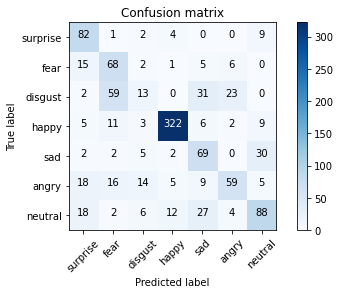

              precision    recall  f1-score   support

    surprise       0.58      0.84      0.68        98
        fear       0.43      0.70      0.53        97
     disgust       0.29      0.10      0.15       128
       happy       0.93      0.90      0.91       358
         sad       0.47      0.63      0.54       110
       angry       0.63      0.47      0.54       126
     neutral       0.62      0.56      0.59       157

    accuracy                           0.65      1074
   macro avg       0.56      0.60      0.56      1074
weighted avg       0.65      0.65      0.64      1074



In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools


cm = confusion_matrix(targs, preds)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm, emotion7_list)

from sklearn.metrics import classification_report

print(classification_report(targs, preds, target_names=emotion7_list))

#### For pytorch model inference

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models

class Res18Feature(nn.Module):
    def __init__(self, pretrained, num_classes = 7):
        super(Res18Feature, self).__init__()
        resnet  = models.resnet18(pretrained)
        # self.feature = nn.Sequential(*list(resnet.children())[:-2]) # before avgpool
        self.features = nn.Sequential(*list(resnet.children())[:-1]) # after avgpool 512x1

        fc_in_dim = list(resnet.children())[-1].in_features # original fc layer's in dimention 512

        self.fc = nn.Linear(fc_in_dim, num_classes) # new fc layer 512x7
        self.alpha = nn.Sequential(nn.Linear(fc_in_dim, 1),nn.Sigmoid())

    def forward(self, x):
        x = self.features(x)

        x = x.view(x.size(0), -1)

        attention_weights = self.alpha(x)
        out = attention_weights * self.fc(x)
        return attention_weights, out

In [4]:
from pathlib import Path

model_save_path = Path(r"C:\Users\xx\Desktop\Workspace\yoozoo-selfcurenetwork\checkpoints\epoch_41_acc_0.8730999827384949.pth")
res18 = Res18Feature(pretrained = False)
checkpoint = torch.load(model_save_path)
res18.load_state_dict(checkpoint['model_state_dict'])
res18.cuda()
res18.eval()
print("model loaded")

model loaded


In [13]:
from pathlib import Path
ROOT = Path(r"C:\Users\xx\Desktop\Workspace\selfcurenetwork-own\NTU-Data\manual-relabel")
# str(ROOT)
import torchvision
from torchvision import transforms

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

ntu_ds = torchvision.datasets.ImageFolder(str(ROOT), transform=data_transforms)
ntu_dl = torch.utils.data.DataLoader(ntu_ds,
                                         batch_size = 32,
                                         num_workers = 0,
                                         shuffle = False,
                                         pin_memory = True)

Confusion matrix, without normalization
[[  0   0   0   0   0 126   0]
 [  0   0   0   0   0 128   0]
 [  0   0   0   0   0  97   0]
 [  0   0   0   0   0 358   0]
 [  0   0   0   0   0 157   0]
 [  0   0   0   0   0 110   0]
 [  0   0   0   0   0  98   0]]


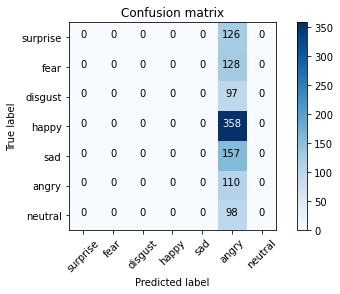

              precision    recall  f1-score   support

    surprise       0.00      0.00      0.00       126
        fear       0.00      0.00      0.00       128
     disgust       0.00      0.00      0.00        97
       happy       0.00      0.00      0.00       358
         sad       0.00      0.00      0.00       157
       angry       0.10      1.00      0.19       110
     neutral       0.00      0.00      0.00        98

    accuracy                           0.10      1074
   macro avg       0.01      0.14      0.03      1074
weighted avg       0.01      0.10      0.02      1074



C:\Users\xx\miniconda3\envs\fastai\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
preds = []
targs = []

for batch_i, (imgs, targets) in enumerate(ntu_dl):

    _, outputs = res18(imgs.cuda())
    _, predicts = torch.max(outputs, 1)
    targets = targets.cuda()
    
    predicts, targets = predicts.tolist(), targets.tolist()
    preds.extend(predicts)
    targs.extend(targets)
    
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools


cm = confusion_matrix(targs, preds)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm, emotion7_list)

from sklearn.metrics import classification_report

print(classification_report(targs, preds, target_names=emotion7_list))